In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Downloading PyTorch Geometric

import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

print(f'▶︎ Successfully installed PyTorch {TORCH} with CUDA {CUDA}')

Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
▶︎ Successfully installed PyTorch 2.8.0 with CUDA cu126


In [ ]:
# 3. Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from scipy.stats import ttest_ind

print("▶︎ Finished Environment Setting")

▶︎ Finished Environment Setting


In [ ]:
import sys
print(sys.version)

3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]


In [ ]:
# --- Set Data Directories ---

# Schaefer Atlas
CN_FC_SCHAEFER_DIR = Path('/content/drive/MyDrive/AD_fMRI_GNN/CN_conn_roi_data/schaefer/fc')
CN_ROI_SCHAEFER_DIR = Path('/content/drive/MyDrive/AD_fMRI_GNN/CN_conn_roi_data/schaefer/roi')
AD_FC_SCHAEFER_DIR = Path('/content/drive/MyDrive/AD_fMRI_GNN/AD_conn_roi_data/schaefer/fc')
AD_ROI_SCHAEFER_DIR = Path('/content/drive/MyDrive/AD_fMRI_GNN/AD_conn_roi_data/schaefer/roi')

# AAL Atlas
CN_FC_AAL_DIR = Path('/content/drive/MyDrive/AD_fMRI_GNN/CN_conn_roi_data/aal/fc')
CN_ROI_AAL_DIR = Path('/content/drive/MyDrive/AD_fMRI_GNN/CN_conn_roi_data/aal/roi')
AD_FC_AAL_DIR = Path('/content/drive/MyDrive/AD_fMRI_GNN/AD_conn_roi_data/aal/fc')
AD_ROI_AAL_DIR = Path('/content/drive/MyDrive/AD_fMRI_GNN/AD_conn_roi_data/aal/roi')


# --- Set Hyperparameters ---
P_VALUE_THRESHOLD = 0.02
LEARNING_RATE = 0.001
BATCH_SIZE = 32
INNER_NUM_EPOCHS = 30
OUTER_NUM_EPOCHS = 100
DROPOUT_RATE = 0.5

print("▶︎ Finished Drive Mount and Directory Settings.")


▶︎ Finished Drive Mount and Directory Settings.


In [ ]:
import os # Import os for path joining
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

class fMRIDataset(Dataset):
    """
    Processing fMRI Dataset for single Atlas (AAL or Schaefer) using KNN graph.
    """
    # Modified __init__ to accept k_neighbors
    def __init__(self, root, cn_fc_dir, cn_roi_dir, ad_fc_dir, ad_roi_dir, k_neighbors=10, transform=None, pre_transform=None):
        self.cn_fc_dir = cn_fc_dir
        self.cn_roi_dir = cn_roi_dir
        self.ad_fc_dir = ad_fc_dir
        self.ad_roi_dir = ad_roi_dir
        self.k_neighbors = k_neighbors # Store k_neighbors for KNN graph

        # Determine atlas_type based on directory names
        if 'schaefer' in str(cn_fc_dir).lower():
            self.atlas_type = 'schaefer'
        elif 'aal' in str(cn_fc_dir).lower():
            self.atlas_type = 'aal'
        else:
            self.atlas_type = 'unknown'
            print(f"Warning: Could not determine atlas type from directory names: {cn_fc_dir}")


        self.ad_subjects = [f.stem.split('_')[0] for f in self.ad_fc_dir.glob('*.csv')]
        self.cn_subjects = [f.stem.split('_')[0] for f in self.cn_fc_dir.glob('*.csv')]
        self.all_subjects = sorted(list(set(self.ad_subjects + self.cn_subjects)))

        # Ensure all subjects have both FC and ROI files, otherwise exclude them.
        valid_subjects = []
        for sub in self.all_subjects:
            # Construct expected file paths based on subject and determined atlas type
            expected_fc_path = (self.ad_fc_dir / f"{sub}_task-rest_bold_{self.atlas_type}_connectivity_matrix.csv") if sub in self.ad_subjects else (self.cn_fc_dir / f"{sub}_task-rest_bold_{self.atlas_type}_connectivity_matrix.csv")
            expected_roi_path = (self.ad_roi_dir / f"{sub}_task-rest_bold_{self.atlas_type}_roi_timeseries.csv") if sub in self.ad_subjects else (self.cn_roi_dir / f"{sub}_task-rest_bold_{self.atlas_type}_roi_timeseries.csv")

            # Use glob with a more specific pattern to find the file if naming is slightly inconsistent
            # Or just check if the constructed path exists for strict naming
            fc_found = expected_fc_path.exists() or list(self.ad_fc_dir.glob(f"{sub}*connectivity_matrix.csv")) or list(self.cn_fc_dir.glob(f"{sub}*connectivity_matrix.csv"))
            roi_found = expected_roi_path.exists() or list(self.ad_roi_dir.glob(f"{sub}*roi_timeseries.csv")) or list(self.cn_roi_dir.glob(f"{sub}*roi_timeseries.csv"))


            if fc_found and roi_found:
                valid_subjects.append(sub)
            else:
                if not fc_found and not roi_found:
                    print(f"Warning: FC and ROI data missing for subject {sub}. Skipping.")
                elif not fc_found:
                    print(f"Warning: FC data missing for subject {sub}. Skipping.")
                elif not roi_found:
                     print(f"Warning: ROI data missing for subject {sub}. Skipping.")


        self.all_subjects = valid_subjects
        self.ad_subjects = [sub for sub in self.all_subjects if sub in self.ad_subjects]
        self.cn_subjects = [sub for sub in self.all_subjects if sub in self.cn_subjects]

        print(f"Initialized dataset with {len(self.all_subjects)} valid subjects.")


        super(fMRIDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
         # This method is typically for raw files that need processing.
         cn_files = [f.name for f in self.cn_fc_dir.glob('*.csv')] + [f.name for f in self.cn_roi_dir.glob('*.csv')]
         ad_files = [f.name for f in self.ad_fc_dir.glob('*.csv')] + [f.name for f in self.ad_roi_dir.glob('*.csv')]
         return list(set(cn_files + ad_files)) # Return unique file names


    @property
    def processed_file_names(self):
        # Define the names of the processed data files
        return [f'data_{i}.pt' for i in range(len(self.all_subjects))]

    # Removed _get_adj_matrix

    def download(self):
        # Download logic here if needed.
        pass

    def process(self):
        # Process raw data into PyTorch Geometric Data objects
        print(f"Processing {len(self.all_subjects)} subjects...")
        for idx, subject_id in enumerate(self.all_subjects):
            print(f"Processing subject {subject_id} ({idx + 1}/{len(self.all_subjects)})...")

            # Determine file paths based on subject group and stored atlas type
            if subject_id in self.ad_subjects:
                label = 1
                fc_dir, roi_dir = self.ad_fc_dir, self.ad_roi_dir
            else:
                label = 0
                fc_dir, roi_dir = self.cn_fc_dir, self.cn_roi_dir

            # Find the actual FC and ROI file paths for the subject
            fc_path_candidates = list(fc_dir.glob(f"{subject_id}*connectivity_matrix.csv"))
            roi_path_candidates = list(roi_dir.glob(f"{subject_id}*roi_timeseries.csv"))

            fc_path = fc_path_candidates[0] if fc_path_candidates else None
            roi_path = roi_path_candidates[0] if roi_path_candidates else None


            if fc_path is None or roi_path is None:
                 print(f"Error during processing: Data for subject {subject_id} not found at expected paths. Skipping.")
                 continue


            try:
                fc_matrix = pd.read_csv(fc_path, index_col=0).values
                roi_data = pd.read_csv(roi_path).values
                print(f"  Successfully loaded data. FC shape: {fc_matrix.shape}, ROI shape: {roi_data.shape}")
            except Exception as e:
                print(f"Error reading files for subject {subject_id}: {e}. Skipping.")
                continue

            # --- Robust ROI Data Transposition Logic (Kept from previous version) ---
            initial_roi_shape = roi_data.shape
            expected_nodes = fc_matrix.shape[0]

            if initial_roi_shape[0] == expected_nodes:
                pass
            elif initial_roi_shape[1] == expected_nodes:
                roi_data = roi_data.T
                print(f"  Transposed ROI data for subject {subject_id}. Initial shape: {initial_roi_shape}, New shape: {roi_data.shape}")
            else:
                print(f"Warning: ROI data shape mismatch for subject {subject_id}. Expected one dimension to match number of nodes ({expected_nodes}), got shape {initial_roi_shape}. Skipping.")
                continue

            if roi_data.shape[0] != expected_nodes:
                 print(f"Error: ROI data first dimension still does not match expected nodes after transposition logic for subject {subject_id}. Expected {expected_nodes}, got {roi_data.shape[0]}. Skipping.")
                 continue


            # --- Define Node Features (x) ---
            # Use the rows of the FC matrix as node features
            x = torch.tensor(fc_matrix, dtype=torch.float)
            num_nodes = x.shape[0]
            print(f"  Node features (x) shape: {x.shape}")

            # --- Implement KNN Graph Construction and Edge Weighting ---
            edge_index = []
            edge_attr = []

            # Use NearestNeighbors to find k_neighbors for each node
            # We can use euclidean distance or cosine similarity. Let's use euclidean distance for now.
            nn = NearestNeighbors(n_neighbors=self.k_neighbors + 1, metric='euclidean') # +1 to exclude self
            nn.fit(x.cpu().numpy()) # Fit on CPU numpy array

            # Find neighbors and distances
            # distances, indices shape: (num_nodes, k_neighbors + 1)
            distances, indices = nn.kneighbors(x.cpu().numpy())

            for i in range(num_nodes):
                # Connect node i to its k_neighbors (excluding itself)
                for j in range(1, self.k_neighbors + 1): # Start from 1 to skip self
                    neighbor_index = indices[i, j]
                    distance = distances[i, j]

                    # Add directed edge from i to neighbor_index
                    edge_index.append([i, neighbor_index])

                    # Calculate edge weight based on distance (e.g., inverse distance or similarity)
                    # Using inverse distance as weight: smaller distance -> larger weight
                    # Add a small epsilon to avoid division by zero for distance 0
                    weight = 1.0 / (distance + 1e-8)
                    # Or using similarity (e.g., 1 - normalized euclidean distance or cosine similarity)
                    # For euclidean distance, smaller is better. Let's use 1 / distance.
                    # For cosine similarity, larger is better. Cosine similarity is calculated between vectors.
                    # Let's stick to inverse euclidean distance for simplicity for now.
                    edge_attr.append([weight])


            # Convert lists to tensors
            if not edge_index: # Handle case with no edges (e.g., k=0 or issues)
                edge_index = torch.empty((2, 0), dtype=torch.long)
                edge_attr = torch.empty((0, 1), dtype=torch.float)
            else:
                edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
                edge_attr = torch.tensor(edge_attr, dtype=torch.float)

            # Ensure edge_index has correct shape (2, num_edges)
            if edge_index.ndim != 2 or edge_index.shape[0] != 2:
                 print(f"Error creating edge_index for subject {subject_id}. Skipping.")
                 continue


            # Create PyTorch Geometric Data object
            # Node features x are already set to FC matrix rows (num_nodes, fc_matrix_cols)
            data = Data(x=x,
                        edge_index=edge_index,
                        edge_attr=edge_attr, # Add edge attributes
                        y=torch.tensor([label], dtype=torch.long))

            # Save the processed data object
            save_path = os.path.join(self.processed_dir, f'data_{idx}.pt')
            try:
                torch.save(data, save_path)
            except Exception as e:
                print(f"Error saving processed data for subject {subject_id} to {save_path}: {e}. Skipping.")
                continue


        print("Finished processing subjects.")


    def get(self, idx):
        # Load a processed data object from the processed directory
        data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'), weights_only=False)
        return data

    def len(self) -> int:
        """Returns the number of data objects stored in the dataset."""
        return len(self.all_subjects) # The number of subjects is the number of samples


    @property
    def num_node_features(self):
        # The number of node features is the number of columns in the FC matrix
        # Load the first processed data object to get the feature dimension
        if len(self.processed_file_names) > 0:
             try:
                 first_processed_file = os.path.join(self.processed_dir, self.processed_file_names[0])
                 if os.path.exists(first_processed_file):
                     data = torch.load(first_processed_file, weights_only=False)
                     # data.x should be (num_nodes, fc_matrix_cols)
                     return data.x.shape[1] # num_node_features is the second dimension (FC matrix columns)
                 else:
                     print(f"Warning: First processed file not found at {first_processed_file}. Cannot determine num_node_features.")
                     return 0
             except Exception as e:
                 print(f"Error loading first processed file to determine num_node_features: {e}")
                 return 0
        return 0

    @property
    def num_classes(self):
        # Assuming binary classification (CN vs AD)
        return 2

In [ ]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data # Import Data for type hinting if needed
import torch

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_channels=64):
        super(GCN, self).__init__()
        # GCNConv doesn't natively handle edge weights in the forward pass directly as a separate argument.
        # To use weighted edges with GCNConv, one common approach is to incorporate weights into the adjacency matrix
        # representation (edge_index and edge_attr). PyG's GCNConv expects edge_index and potentially edge_attr
        # to represent the graph structure and weights, and handles normalization internally based on how
        # the MessagePassing base class is implemented and how weights are passed and used in message/aggregate.
        # Looking at PyG's GCNConv source or documentation would confirm how it uses edge_attr.
        # Assuming GCNConv can take edge_attr, we pass it in the forward method.
        # If GCNConv's 'propagate' method uses edge_attr in the 'message' function, this will work.
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin1 = Linear(hidden_channels, num_classes)
        self.dropout = Dropout(p=DROPOUT_RATE)

    def forward(self, data):
        # Data object now contains edge_attr
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # Pass edge_attr to GCNConv layers. GCNConv's forward expects edge_index and optionally edge_weight.
        # In PyG, edge_attr is typically used for multi-dimensional edge features, while edge_weight
        # is for scalar weights. We generated scalar weights, so let's rename edge_attr to edge_weight
        # when passing to GCNConv, and ensure its shape is [num_edges].
        # Our edge_attr from the dataset is [num_edges, 1]. We need to squeeze it to [num_edges].
        edge_weight = edge_attr.squeeze() if edge_attr is not None else None

        x = self.conv1(x, edge_index, edge_weight) # Pass edge_weight here
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index, edge_weight) # Pass edge_weight here
        x = F.relu(x)

        # Global pooling remains the same
        x = global_mean_pool(x, batch)
        x = self.dropout(x)
        x = self.lin1(x)
        return F.log_softmax(x, dim=-1)

print("▶︎ Finished Defining Dataset Class and GCN Model (Modified for weighted edges).")

▶︎ Finished Defining Dataset Class and GCN Model (Modified for weighted edges).


In [ ]:
#@title 4. Model training function & evaluation function
# ==============================================================================
#   Defining Functions for Training and Testing model
# ==============================================================================
from tqdm import tqdm # Import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score # Import necessary metrics

def train_model(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    # Wrap the loader with tqdm for a progress bar
    for data in tqdm(loader, desc="Training"):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def test_model(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())
            all_probs.extend(torch.exp(out).cpu().numpy()) # log_softmax -> softmax

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    # Calculate AUC, ensure there's at least one positive sample and probabilities are correctly shaped
    auc_score = 0 # Default AUC if calculation fails
    if len(np.unique(all_labels)) > 1 and np.array(all_probs).shape[1] == 2:
        try:
            # Get probability of the positive class (AD, label 1)
            probs_positive_class = np.array(all_probs)[:, 1]
            auc_score = roc_auc_score(all_labels, probs_positive_class)
        except Exception as e:
            print(f"Warning: Could not calculate AUC: {e}")
            auc_score = 0

    # Calculate Recall for the positive class (AD, label 1)
    recall = 0 # Default recall if calculation fails or no positive samples
    if len(all_labels) > 0 and 1 in all_labels:
        try:
            recall = recall_score(all_labels, all_preds, pos_label=1)
        except Exception as e:
            print(f"Warning: Could not calculate Recall: {e}")
            recall = 0


    return accuracy, f1, auc_score, recall, all_preds, all_labels, np.array(all_probs)

def plot_confusion_matrix(cm, class_names, title):
    """
    Visualising Confusion Matrix
    """
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(6, 5))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues')
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

print("▶︎ Finished Defining Training and Testing Function.")

▶︎ Finished Defining Training and Testing Function.


In [ ]:
#@title 5. Train and Save Each Atlas' Model
# ==============================================================================
# Training GCN model to Schaefer and AAL Dataset respectively,
# & Save the weight
# ==============================================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Current Device: {device}")


🖥️ Current Device: cuda


In [ ]:
# --- Model Training  ---
def run_training(atlas_name, dataset, num_epochs=100):
    print("-" * 50)
    print(f"▶︎ Start Training {atlas_name} Atlas Model ...")

    # Data Splitting
    train_idx, test_idx = train_test_split(
        np.arange(len(dataset)),
        test_size=0.2,
        random_state=42,
        stratify=[data.y.item() for data in dataset]
    )
    train_dataset = dataset[train_idx]
    test_dataset = dataset[test_idx]
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Initialise Model, Optimiser, Loss function
    model = GCN(
        num_node_features=dataset.num_node_features,
        num_classes=dataset.num_classes,
        hidden_channels=64
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = torch.nn.CrossEntropyLoss()

    # Training the model
    for epoch in range(1, num_epochs + 1):
        loss = train_model(model, train_loader, criterion, optimizer, device)
        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

    # Evaluating the model
    test_acc, test_f1, test_auc, test_recall, _, _, _ = test_model(model, test_loader, device) # Capture all returned metrics
    print(f"{atlas_name} Model Test Accuracy: {test_acc:.4f}")
    print(f"{atlas_name} Model Test F1-Score: {test_f1:.4f}")
    print(f"{atlas_name} Model Test AUC: {test_auc:.4f}")
    print(f"{atlas_name} Model Test Recall (AD): {test_recall:.4f}")


    # Saving the trained model
    model_save_path = f'./{atlas_name}_gcn_model.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f"{atlas_name} model is save in the path: '{model_save_path}'.")
    print("-" * 50)

    return model, test_loader


 Starting AAL Model Cross-Validation with KNN Graph

Initialized dataset with 289 valid subjects.

=============== FOLD 1/10 ================
Initialized dataset with 289 valid subjects.

Fold 1: Training AAL Model with KNN Graph...


Training: 100%|██████████| 9/9 [00:00<00:00, 35.10it/s]


  AAL Epoch: 010, Train Loss: 0.6376


Training: 100%|██████████| 9/9 [00:00<00:00, 50.98it/s]


  AAL Epoch: 020, Train Loss: 0.5849


Training: 100%|██████████| 9/9 [00:00<00:00, 48.81it/s]


  AAL Epoch: 030, Train Loss: 0.4705
Fold 1 Test Accuracy: 0.6552, AUC: 0.7579, Recall (AD): 0.2000

=============== FOLD 2/10 ================
Initialized dataset with 289 valid subjects.

Fold 2: Training AAL Model with KNN Graph...


Training: 100%|██████████| 9/9 [00:00<00:00, 49.66it/s]


  AAL Epoch: 010, Train Loss: 0.6244


Training: 100%|██████████| 9/9 [00:00<00:00, 49.41it/s]


  AAL Epoch: 020, Train Loss: 0.5667


Training: 100%|██████████| 9/9 [00:00<00:00, 48.78it/s]


  AAL Epoch: 030, Train Loss: 0.4278
Fold 2 Test Accuracy: 0.6897, AUC: 0.7421, Recall (AD): 0.2000

=============== FOLD 3/10 ================
Initialized dataset with 289 valid subjects.

Fold 3: Training AAL Model with KNN Graph...


Training: 100%|██████████| 9/9 [00:00<00:00, 37.85it/s]


  AAL Epoch: 010, Train Loss: 0.6335


Training: 100%|██████████| 9/9 [00:00<00:00, 45.12it/s]


  AAL Epoch: 020, Train Loss: 0.5690


Training: 100%|██████████| 9/9 [00:00<00:00, 49.24it/s]


  AAL Epoch: 030, Train Loss: 0.4509
Fold 3 Test Accuracy: 0.7586, AUC: 0.7684, Recall (AD): 0.6000

=============== FOLD 4/10 ================
Initialized dataset with 289 valid subjects.

Fold 4: Training AAL Model with KNN Graph...


Training: 100%|██████████| 9/9 [00:00<00:00, 45.72it/s]


  AAL Epoch: 010, Train Loss: 0.6303


Training: 100%|██████████| 9/9 [00:00<00:00, 49.65it/s]


  AAL Epoch: 020, Train Loss: 0.5528


Training: 100%|██████████| 9/9 [00:00<00:00, 50.38it/s]


  AAL Epoch: 030, Train Loss: 0.4274
Fold 4 Test Accuracy: 0.5172, AUC: 0.5947, Recall (AD): 0.2000

=============== FOLD 5/10 ================
Initialized dataset with 289 valid subjects.

Fold 5: Training AAL Model with KNN Graph...


Training: 100%|██████████| 9/9 [00:00<00:00, 34.42it/s]


  AAL Epoch: 010, Train Loss: 0.6329


Training: 100%|██████████| 9/9 [00:00<00:00, 33.60it/s]


  AAL Epoch: 020, Train Loss: 0.5629


Training: 100%|██████████| 9/9 [00:00<00:00, 50.64it/s]


  AAL Epoch: 030, Train Loss: 0.4141
Fold 5 Test Accuracy: 0.6207, AUC: 0.7121, Recall (AD): 0.3636

=============== FOLD 6/10 ================
Initialized dataset with 289 valid subjects.

Fold 6: Training AAL Model with KNN Graph...


Training: 100%|██████████| 9/9 [00:00<00:00, 48.81it/s]


  AAL Epoch: 010, Train Loss: 0.6341


Training: 100%|██████████| 9/9 [00:00<00:00, 49.77it/s]


  AAL Epoch: 020, Train Loss: 0.5571


Training: 100%|██████████| 9/9 [00:00<00:00, 46.82it/s]


  AAL Epoch: 030, Train Loss: 0.3975
Fold 6 Test Accuracy: 0.6897, AUC: 0.7273, Recall (AD): 0.1818

=============== FOLD 7/10 ================
Initialized dataset with 289 valid subjects.

Fold 7: Training AAL Model with KNN Graph...


Training: 100%|██████████| 9/9 [00:00<00:00, 50.09it/s]


  AAL Epoch: 010, Train Loss: 0.6313


Training: 100%|██████████| 9/9 [00:00<00:00, 39.28it/s]


  AAL Epoch: 020, Train Loss: 0.5722


Training: 100%|██████████| 9/9 [00:00<00:00, 50.16it/s]


  AAL Epoch: 030, Train Loss: 0.4452
Fold 7 Test Accuracy: 0.6897, AUC: 0.8182, Recall (AD): 0.3636

=============== FOLD 8/10 ================
Initialized dataset with 289 valid subjects.

Fold 8: Training AAL Model with KNN Graph...


Training: 100%|██████████| 9/9 [00:00<00:00, 48.58it/s]


  AAL Epoch: 010, Train Loss: 0.6321


Training: 100%|██████████| 9/9 [00:00<00:00, 51.24it/s]


  AAL Epoch: 020, Train Loss: 0.5830


Training: 100%|██████████| 9/9 [00:00<00:00, 42.18it/s]


  AAL Epoch: 030, Train Loss: 0.4602
Fold 8 Test Accuracy: 0.6897, AUC: 0.8586, Recall (AD): 0.2727

=============== FOLD 9/10 ================
Initialized dataset with 289 valid subjects.

Fold 9: Training AAL Model with KNN Graph...


Training: 100%|██████████| 9/9 [00:00<00:00, 45.56it/s]


  AAL Epoch: 010, Train Loss: 0.6323


Training: 100%|██████████| 9/9 [00:00<00:00, 32.44it/s]


  AAL Epoch: 020, Train Loss: 0.5743


Training: 100%|██████████| 9/9 [00:00<00:00, 46.94it/s]


  AAL Epoch: 030, Train Loss: 0.4178
Fold 9 Test Accuracy: 0.8276, AUC: 0.9192, Recall (AD): 0.6364

=============== FOLD 10/10 ================
Initialized dataset with 289 valid subjects.

Fold 10: Training AAL Model with KNN Graph...


Training: 100%|██████████| 9/9 [00:00<00:00, 50.22it/s]


  AAL Epoch: 010, Train Loss: 0.6327


Training: 100%|██████████| 9/9 [00:00<00:00, 45.15it/s]


  AAL Epoch: 020, Train Loss: 0.5577


Training: 100%|██████████| 9/9 [00:00<00:00, 47.60it/s]


  AAL Epoch: 030, Train Loss: 0.4388
Fold 10 Test Accuracy: 0.6071, AUC: 0.6611, Recall (AD): 0.5000

=============== Cross-Validation Complete ===============

10-Fold Cross-validation Result (AAL with KNN Graph):
  - Average Test Accuracy: 0.6745
  - Average Test AUC: 0.7560
  - Average Test Recall (AD): 0.3518
  - Average Test F1-Score: 0.6507


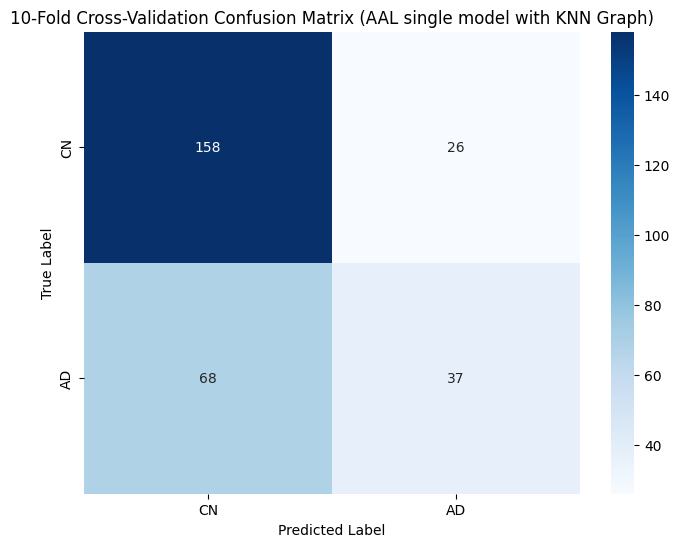


Classification Report:
              precision    recall  f1-score   support

          CN     0.6991    0.8587    0.7707       184
          AD     0.5873    0.3524    0.4405       105

    accuracy                         0.6747       289
   macro avg     0.6432    0.6055    0.6056       289
weighted avg     0.6585    0.6747    0.6507       289



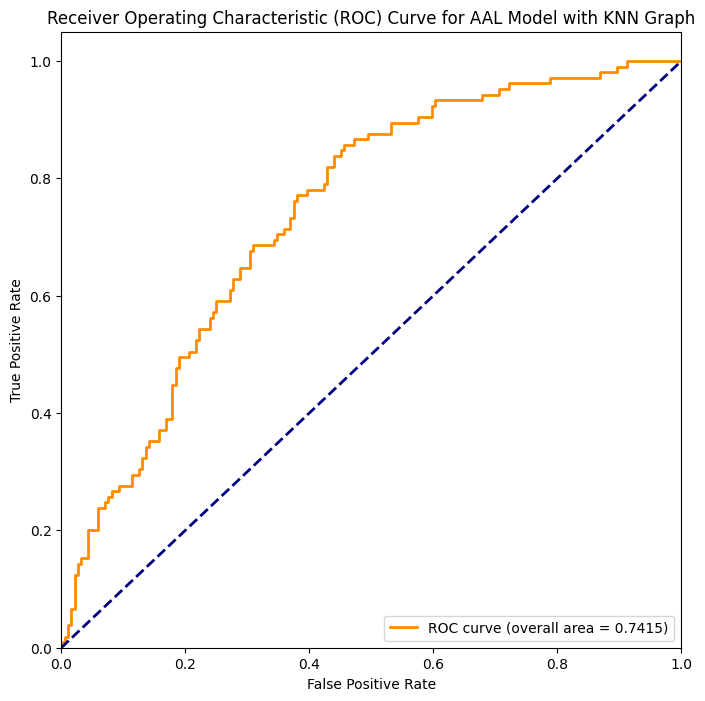

In [ ]:
#@title Single Model Cross-Validation AAL (without hyperparmeter tuning)
# ==============================================================================
# Performing Cross-Validation for the single Model (AAL GCN)
# Using KNN-based graph construction
# ==============================================================================
from sklearn.model_selection import StratifiedKFold
import gc
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, roc_curve, auc, roc_auc_score, recall_score # Import recall_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*80)
print(" Starting AAL Model Cross-Validation with KNN Graph")
print("="*80 + "\n")

# --- 1. Cross-Validation Setup ---
K_FOLDS = 10
NUM_EPOCHS = 30
K_NEIGHBORS = 10 # Define K for KNN graph construction

# Use a single StratifiedKFold instance to split indices for both datasets
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

# Lists to store results for each Fold (using specific names for AAL)
aal_fold_history = []
all_aal_preds = []
all_aal_labels = []
all_aal_probs = []

# --- 2. Load Full Dataset Info for subject list and labels ---

# We load the full dataset info here to get the initial subject list and labels for splitting.
# The actual dataset instances used within the loop will be re-instantiated
# with the fold-specific data using the KNN graph construction.

# AAL Full Dataset Info (used only for subject list and labels for splitting)
full_dataset_aal_info = fMRIDataset(
    root='./data/aal_full_cv_info', # Temporary root folder for AAL full dataset info
    cn_fc_dir=CN_FC_AAL_DIR, cn_roi_dir=CN_ROI_AAL_DIR,
    ad_fc_dir=AD_FC_AAL_DIR, ad_roi_dir=AD_ROI_AAL_DIR,
    k_neighbors=K_NEIGHBORS
)


# Use labels from this dataset for stratification
dataset_labels = [data.y.item() for data in full_dataset_aal_info]

# Store the full subject list for easier file path retrieval
full_subject_list = full_dataset_aal_info.all_subjects
full_cn_subjects = full_dataset_aal_info.cn_subjects
full_ad_subjects = full_dataset_aal_info.ad_subjects


# --- 3. Start Cross-Validation Loop ---
for fold, (train_idx, test_idx) in enumerate(skf.split(np.arange(len(full_subject_list)), dataset_labels)):
    print(f"\n=============== FOLD {fold+1}/{K_FOLDS} ================")

    # --- 4. Create Fold-specific Datasets and Data Loaders using KNN graph ---

    # Re-instantiate AAL dataset/loader for the current fold using KNN graph construction
    # The process method will be called when the dataset is accessed, building the KNN graph
    dataset_aal_fold_knn = fMRIDataset(
        root=f'./data/aal_fold_{fold+1}_knn', # Use a unique root for each fold's processed data
        cn_fc_dir=CN_FC_AAL_DIR, cn_roi_dir=CN_ROI_AAL_DIR,
        ad_fc_dir=AD_FC_AAL_DIR, ad_roi_dir=AD_ROI_AAL_DIR,
        k_neighbors=K_NEIGHBORS # Pass K for KNN
    )
    # Create Subset and DataLoader for AAL using the dataset with KNN graph
    train_dataset_aal_fold_knn = torch.utils.data.Subset(dataset_aal_fold_knn, train_idx)
    test_dataset_aal_fold_knn = torch.utils.data.Subset(dataset_aal_fold_knn, test_idx)
    train_loader_aal_knn = DataLoader(train_dataset_aal_fold_knn, batch_size=BATCH_SIZE, shuffle=True)
    test_loader_aal_knn = DataLoader(test_dataset_aal_fold_knn, batch_size=BATCH_SIZE, shuffle=False)


    # --- 5 & 6. Initialize and Train Model within the Fold ---
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize and Train AAL Model using the KNN graph data loader
    print(f"\nFold {fold+1}: Training AAL Model with KNN Graph...")
    model_aal_fold = GCN(
        # Use num_node_features and num_classes from the fold-specific dataset
        num_node_features=dataset_aal_fold_knn.num_node_features,
        num_classes=dataset_aal_fold_knn.num_classes
    ).to(device)
    optimizer_aal = torch.optim.Adam(model_aal_fold.parameters(), lr=LEARNING_RATE)
    criterion_aal = torch.nn.CrossEntropyLoss()

    for epoch in range(1, NUM_EPOCHS + 1):
        loss = train_model(model_aal_fold, train_loader_aal_knn, criterion_aal, optimizer_aal, device)
        if epoch % 10 == 0: # Reduced print frequency for cleaner output
             print(f'  AAL Epoch: {epoch:03d}, Train Loss: {loss:.4f}')


    # --- 7. Obtain Prediction Probabilities and Labels on Test Data within the Fold ---
    # Use the test loader with KNN graph data
    test_accuracy, test_f1, test_auc, test_recall, preds_aal_test, labels_aal_test, probs_aal_test = test_model(model_aal_fold, test_loader_aal_knn, device)


    current_fold_true_labels = np.array(labels_aal_test)

    # --- Calculate AUC for the current fold's test set ---
    fold_auc = 0 # Default AUC if calculation fails
    # Ensure probs_aal_test is in the correct format and labels are binary
    if probs_aal_test is not None and probs_aal_test.shape[1] == 2 and len(current_fold_true_labels) == len(probs_aal_test):
        try:
            # Get probability of the positive class (AD, label 1)
            probs_positive_class_fold = probs_aal_test[:, 1]
            fold_auc = roc_auc_score(current_fold_true_labels, probs_positive_class_fold)
        except Exception as e:
            print(f"Warning: Could not calculate AUC for fold {fold+1}: {e}")
            fold_auc = 0 # Set to 0 or NaN if calculation fails

    # --- Calculate Recall for the positive class (AD, label 1) ---
    fold_recall = 0 # Default recall if calculation fails or no positive samples
    if len(current_fold_true_labels) > 0 and 1 in current_fold_true_labels:
        try:
            fold_recall = recall_score(current_fold_true_labels, preds_aal_test, pos_label=1)
        except Exception as e:
            print(f"Warning: Could not calculate Recall for fold {fold+1}: {e}")
            fold_recall = 0


    # --- 9. Evaluate Fold Performance and Collect Results (using specific names for AAL) ---
    fold_accuracy = accuracy_score(current_fold_true_labels, preds_aal_test)
    # Store accuracy, AUC, and Recall in fold_history
    aal_fold_history.append({'acc': fold_accuracy, 'auc': fold_auc, 'recall': fold_recall}) # Added recall
    all_aal_preds.extend(preds_aal_test)
    all_aal_labels.extend(current_fold_true_labels)
    all_aal_probs.extend(probs_aal_test) # Append probabilities for later overall AUC/ROC if needed

    print(f"Fold {fold+1} Test Accuracy: {fold_accuracy:.4f}, AUC: {fold_auc:.4f}, Recall (AD): {fold_recall:.4f}") # Added recall printout

    # --- 10. Memory Cleanup ---
    del model_aal_fold, optimizer_aal, criterion_aal
    # Clean up data loaders and datasets created for this fold
    del train_dataset_aal_fold_knn, test_dataset_aal_fold_knn, train_loader_aal_knn, test_loader_aal_knn
    del dataset_aal_fold_knn # Delete the dataset instance
    gc.collect()
    torch.cuda.empty_cache()

# --- 11. Cross-Validation Complete ---
print("\n=============== Cross-Validation Complete ===============")

# --- Final Result Analysis (using specific names for AAL) ---
if aal_fold_history:
    avg_acc = np.mean([f['acc'] for f in aal_fold_history])
    avg_auc = np.mean([f['auc'] for f in aal_fold_history]) # Calculate average AUC
    avg_recall = np.mean([f['recall'] for f in aal_fold_history]) # Calculate average Recall
    f1 = f1_score(all_aal_labels, all_aal_preds, average='weighted')

    print(f"\n{K_FOLDS}-Fold Cross-validation Result (AAL with KNN Graph):")
    print(f"  - Average Test Accuracy: {avg_acc:.4f}")
    print(f"  - Average Test AUC: {avg_auc:.4f}") # Print average AUC
    print(f"  - Average Test Recall (AD): {avg_recall:.4f}") # Print average Recall
    print(f"  - Average Test F1-Score: {f1:.4f}")

    # Overall Confusion Matrix (using specific names for AAL)
    cm = confusion_matrix(all_aal_labels, all_aal_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['CN', 'AD'], yticklabels=['CN', 'AD'])
    plt.title(f'{K_FOLDS}-Fold Cross-Validation Confusion Matrix (AAL single model with KNN Graph)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
else:
    print("Couldn't execute cross-validation.")


# 1. Classification Report 출력 (using specific names for AAL)
print("\nClassification Report:")
print(classification_report(all_aal_labels, all_aal_preds, target_names=['CN', 'AD'], digits=4))

# =========================================================
# --- ROC Curve and AUC Visualization (using specific names for AAL) ---
# =========================================================
# Ensure all_aal_probs is a numpy array before slicing
all_aal_probs_np = np.array(all_aal_probs)
# Check shape of all_aal_probs_np and select the column corresponding to the positive class (AD, which is label 1)
if all_aal_probs_np.ndim > 1 and all_aal_probs_np.shape[1] > 1:
    # Use the collected probabilities for the overall ROC curve
    probs_positive_class = all_aal_probs_np[:, 1]
else:
    print("Warning: Unexpected shape for all_aal_probs. Cannot plot ROC curve.")
    probs_positive_class = None

if probs_positive_class is not None:
    # Ensure labels and probabilities have the same length
    if len(all_aal_labels) == len(probs_positive_class):
        fpr, tpr, thresholds = roc_curve(all_aal_labels, probs_positive_class)
        roc_auc = auc(fpr, tpr) # This is the AUC for the overall collected predictions/probs

        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (overall area = {roc_auc:.4f})') # Label as overall AUC
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve for AAL Model with KNN Graph')
        plt.legend(loc="lower right")
        plt.show()
    else:
        print(f"Error: Length of test labels ({len(all_aal_labels)}) does not match length of probabilities ({len(probs_positive_class)}). Cannot plot ROC curve.")


 Starting Schaefer Model Cross-Validation with KNN Graph

Initialized dataset with 289 valid subjects.

=============== FOLD 1/10 ================
Initialized dataset with 289 valid subjects.

Fold 1: Training Schaefer Model with KNN Graph...


Training: 100%|██████████| 9/9 [00:00<00:00, 18.84it/s]


  Schaefer Epoch: 010, Train Loss: 0.6083


Training: 100%|██████████| 9/9 [00:00<00:00, 25.47it/s]


  Schaefer Epoch: 020, Train Loss: 0.3461


Training: 100%|██████████| 9/9 [00:00<00:00, 24.26it/s]


  Schaefer Epoch: 030, Train Loss: 0.1528
Fold 1 Test Accuracy: 0.8966, AUC: 0.9316, Recall (AD): 0.8000

=============== FOLD 2/10 ================
Initialized dataset with 289 valid subjects.

Fold 2: Training Schaefer Model with KNN Graph...


Training: 100%|██████████| 9/9 [00:00<00:00, 19.58it/s]


  Schaefer Epoch: 010, Train Loss: 0.5988


Training: 100%|██████████| 9/9 [00:00<00:00, 25.86it/s]


  Schaefer Epoch: 020, Train Loss: 0.3171


Training: 100%|██████████| 9/9 [00:00<00:00, 25.20it/s]


  Schaefer Epoch: 030, Train Loss: 0.1336
Fold 2 Test Accuracy: 0.7931, AUC: 0.9421, Recall (AD): 0.6000

=============== FOLD 3/10 ================
Initialized dataset with 289 valid subjects.

Fold 3: Training Schaefer Model with KNN Graph...


Training: 100%|██████████| 9/9 [00:00<00:00, 25.48it/s]


  Schaefer Epoch: 010, Train Loss: 0.5893


Training: 100%|██████████| 9/9 [00:00<00:00, 24.79it/s]


  Schaefer Epoch: 020, Train Loss: 0.3289


Training: 100%|██████████| 9/9 [00:00<00:00, 24.86it/s]


  Schaefer Epoch: 030, Train Loss: 0.1396
Fold 3 Test Accuracy: 0.8966, AUC: 0.9211, Recall (AD): 0.8000

=============== FOLD 4/10 ================
Initialized dataset with 289 valid subjects.

Fold 4: Training Schaefer Model with KNN Graph...


Training: 100%|██████████| 9/9 [00:00<00:00, 24.81it/s]


  Schaefer Epoch: 010, Train Loss: 0.5671


Training: 100%|██████████| 9/9 [00:00<00:00, 25.26it/s]


  Schaefer Epoch: 020, Train Loss: 0.3038


Training: 100%|██████████| 9/9 [00:00<00:00, 23.70it/s]


  Schaefer Epoch: 030, Train Loss: 0.1367
Fold 4 Test Accuracy: 0.7931, AUC: 0.8579, Recall (AD): 0.5000

=============== FOLD 5/10 ================
Initialized dataset with 289 valid subjects.

Fold 5: Training Schaefer Model with KNN Graph...


Training: 100%|██████████| 9/9 [00:00<00:00, 24.58it/s]


  Schaefer Epoch: 010, Train Loss: 0.5836


Training: 100%|██████████| 9/9 [00:00<00:00, 21.06it/s]


  Schaefer Epoch: 020, Train Loss: 0.3108


Training: 100%|██████████| 9/9 [00:00<00:00, 26.34it/s]


  Schaefer Epoch: 030, Train Loss: 0.1486
Fold 5 Test Accuracy: 0.7931, AUC: 0.8990, Recall (AD): 0.7273

=============== FOLD 6/10 ================
Initialized dataset with 289 valid subjects.

Fold 6: Training Schaefer Model with KNN Graph...


Training: 100%|██████████| 9/9 [00:00<00:00, 25.40it/s]


  Schaefer Epoch: 010, Train Loss: 0.5801


Training: 100%|██████████| 9/9 [00:00<00:00, 20.16it/s]


  Schaefer Epoch: 020, Train Loss: 0.2832


Training: 100%|██████████| 9/9 [00:00<00:00, 25.70it/s]


  Schaefer Epoch: 030, Train Loss: 0.1061
Fold 6 Test Accuracy: 0.7931, AUC: 0.8384, Recall (AD): 0.5455

=============== FOLD 7/10 ================
Initialized dataset with 289 valid subjects.

Fold 7: Training Schaefer Model with KNN Graph...


Training: 100%|██████████| 9/9 [00:00<00:00, 25.70it/s]


  Schaefer Epoch: 010, Train Loss: 0.5783


Training: 100%|██████████| 9/9 [00:00<00:00, 24.92it/s]


  Schaefer Epoch: 020, Train Loss: 0.3338


Training: 100%|██████████| 9/9 [00:00<00:00, 25.40it/s]


  Schaefer Epoch: 030, Train Loss: 0.1506
Fold 7 Test Accuracy: 0.9310, AUC: 0.9242, Recall (AD): 0.8182

=============== FOLD 8/10 ================
Initialized dataset with 289 valid subjects.

Fold 8: Training Schaefer Model with KNN Graph...


Training: 100%|██████████| 9/9 [00:00<00:00, 24.53it/s]


  Schaefer Epoch: 010, Train Loss: 0.5804


Training: 100%|██████████| 9/9 [00:00<00:00, 25.31it/s]


  Schaefer Epoch: 020, Train Loss: 0.3042


Training: 100%|██████████| 9/9 [00:00<00:00, 20.43it/s]


  Schaefer Epoch: 030, Train Loss: 0.1689
Fold 8 Test Accuracy: 0.8276, AUC: 0.8788, Recall (AD): 0.7273

=============== FOLD 9/10 ================
Initialized dataset with 289 valid subjects.

Fold 9: Training Schaefer Model with KNN Graph...


Training: 100%|██████████| 9/9 [00:00<00:00, 24.53it/s]


  Schaefer Epoch: 010, Train Loss: 0.5991


Training: 100%|██████████| 9/9 [00:00<00:00, 25.04it/s]


  Schaefer Epoch: 020, Train Loss: 0.3527


Training: 100%|██████████| 9/9 [00:00<00:00, 19.06it/s]


  Schaefer Epoch: 030, Train Loss: 0.1430
Fold 9 Test Accuracy: 0.7586, AUC: 0.8838, Recall (AD): 0.5455

=============== FOLD 10/10 ================
Initialized dataset with 289 valid subjects.

Fold 10: Training Schaefer Model with KNN Graph...


Training: 100%|██████████| 9/9 [00:00<00:00, 25.10it/s]


  Schaefer Epoch: 010, Train Loss: 0.5788


Training: 100%|██████████| 9/9 [00:00<00:00, 23.91it/s]


  Schaefer Epoch: 020, Train Loss: 0.3020


Training: 100%|██████████| 9/9 [00:00<00:00, 24.94it/s]


  Schaefer Epoch: 030, Train Loss: 0.1271
Fold 10 Test Accuracy: 0.7857, AUC: 0.8778, Recall (AD): 0.9000

=============== Cross-Validation Complete ===============

10-Fold Cross-validation Result (Schaefer with KNN Graph):
  - Average Test Accuracy: 0.8268
  - Average Test AUC: 0.8955
  - Average Test Recall (AD): 0.6964
  - Average Test F1-Score: 0.8240


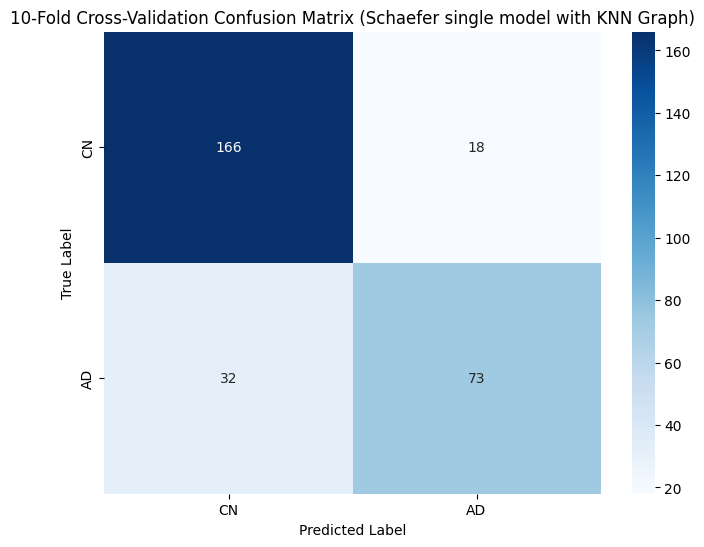


Classification Report:
              precision    recall  f1-score   support

          CN     0.8384    0.9022    0.8691       184
          AD     0.8022    0.6952    0.7449       105

    accuracy                         0.8270       289
   macro avg     0.8203    0.7987    0.8070       289
weighted avg     0.8252    0.8270    0.8240       289



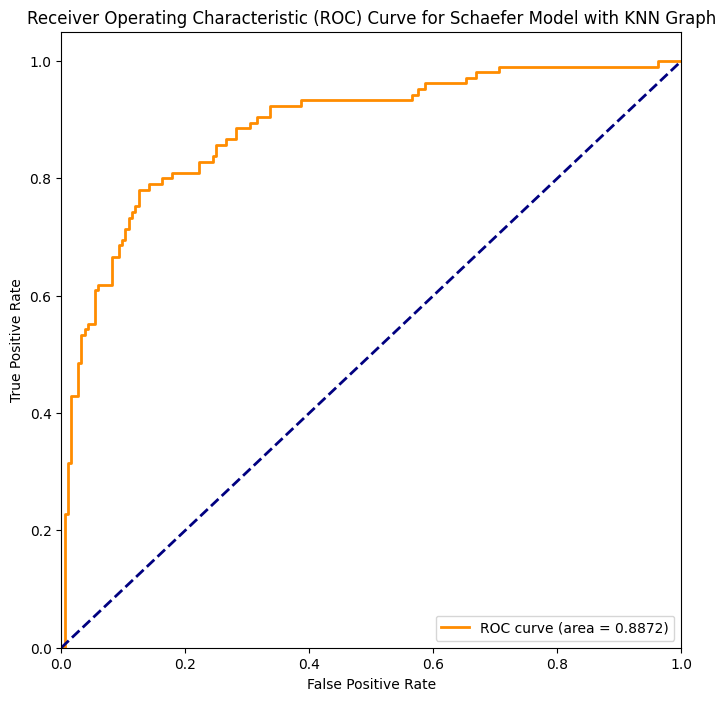

In [ ]:
#@title Single Model Cross-Validation Schaefer (without hyperparmeter tuning)
# ==============================================================================
# Performing Cross-Validation for the single Model (Schaefer GCN)
# Using KNN-based graph construction
# ==============================================================================
from sklearn.model_selection import StratifiedKFold
import gc
import torch
import numpy as np # Added numpy import for np.array
import pandas as pd # Added pandas import
from pathlib import Path # Added Path import
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, roc_curve, auc, roc_auc_score, recall_score # Import recall_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*80)
print(" Starting Schaefer Model Cross-Validation with KNN Graph")
print("="*80 + "\n")

# --- 1. Cross-Validation Setup ---
K_FOLDS = 10
NUM_EPOCHS = 30
K_NEIGHBORS = 10 # Define K for KNN graph construction

# Use a single StratifiedKFold instance to split indices for both datasets
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

# Lists to store results for each Fold (using specific names for Schaefer)
schaefer_fold_history = []
all_schaefer_preds = []
all_schaefer_labels = []
all_schaefer_probs = []

# --- 2. Load Full Dataset Info for subject list and labels ---

# We load the full dataset info here to get the initial subject list and labels for splitting.
# The actual dataset instances used within the loop will be re-instantiated
# with the fold-specific data using the KNN graph construction.

# Schaefer Full Dataset Info (used only for subject list and labels for splitting)
# We don't need significant_edges here anymore as it's not used in the new fMRIDataset __init__
full_dataset_schaefer_info = fMRIDataset(
    root='./data/schaefer_full_cv_info', # Temporary root folder for Schaefer full dataset info
    cn_fc_dir=CN_FC_SCHAEFER_DIR, cn_roi_dir=CN_ROI_SCHAEFER_DIR,
    ad_fc_dir=AD_FC_SCHAEFER_DIR, ad_roi_dir=AD_ROI_SCHAEFER_DIR,
    k_neighbors=K_NEIGHBORS # Pass k_neighbors, though not used for just getting info
)


# Use labels from this dataset for stratification
dataset_labels = [data.y.item() for data in full_dataset_schaefer_info]

# Store the full subject list for easier file path retrieval
full_subject_list = full_dataset_schaefer_info.all_subjects
full_cn_subjects = full_dataset_schaefer_info.cn_subjects
full_ad_subjects = full_dataset_schaefer_info.ad_subjects


# --- 3. Start Cross-Validation Loop ---
for fold, (train_idx, test_idx) in enumerate(skf.split(np.arange(len(full_subject_list)), dataset_labels)):
    print(f"\n=============== FOLD {fold+1}/{K_FOLDS} ================")

    # --- No T-test based feature selection needed here ---
    # The KNN graph construction is done within the fMRIDataset process method
    # for each subject, based on their FC matrix rows.

    # --- 4. Create Fold-specific Datasets and Data Loaders using KNN graph ---

    # Re-instantiate SCHAEFER dataset/loader for the current fold using KNN graph construction
    # The process method will be called when the dataset is accessed, building the KNN graph
    dataset_schaefer_fold_knn = fMRIDataset(
        root=f'./data/schaefer_fold_{fold+1}_knn', # Use a unique root for each fold's processed data
        cn_fc_dir=CN_FC_SCHAEFER_DIR, cn_roi_dir=CN_ROI_SCHAEFER_DIR,
        ad_fc_dir=AD_FC_SCHAEFER_DIR, ad_roi_dir=AD_ROI_SCHAEFER_DIR,
        k_neighbors=K_NEIGHBORS # Pass K for KNN
    )
    # Create Subset and DataLoader for Schaefer using the dataset with KNN graph
    train_dataset_schaefer_fold_knn = torch.utils.data.Subset(dataset_schaefer_fold_knn, train_idx)
    test_dataset_schaefer_fold_knn = torch.utils.data.Subset(dataset_schaefer_fold_knn, test_idx)
    train_loader_schaefer_knn = DataLoader(train_dataset_schaefer_fold_knn, batch_size=BATCH_SIZE, shuffle=True)
    test_loader_schaefer_knn = DataLoader(test_dataset_schaefer_fold_knn, batch_size=BATCH_SIZE, shuffle=False)


    # --- 5 & 6. Initialize and Train Model within the Fold ---
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize and Train Schaefer Model using the KNN graph data loader
    print(f"\nFold {fold+1}: Training Schaefer Model with KNN Graph...")
    model_schaefer_fold = GCN(
        # Use num_node_features and num_classes from the fold-specific dataset
        num_node_features=dataset_schaefer_fold_knn.num_node_features,
        num_classes=dataset_schaefer_fold_knn.num_classes
    ).to(device)
    optimizer_schaefer = torch.optim.Adam(model_schaefer_fold.parameters(), lr=LEARNING_RATE)
    criterion_schaefer = torch.nn.CrossEntropyLoss()

    for epoch in range(1, NUM_EPOCHS + 1):
        loss = train_model(model_schaefer_fold, train_loader_schaefer_knn, criterion_schaefer, optimizer_schaefer, device)
        if epoch % 10 == 0: # Reduced print frequency for cleaner output
             print(f'  Schaefer Epoch: {epoch:03d}, Train Loss: {loss:.4f}')


    # --- 7. Obtain Prediction Probabilities and Labels on Test Data within the Fold ---
    # Use the test loader with KNN graph data
    test_accuracy, test_f1, test_auc, test_recall, preds_schaefer_test, labels_schaefer_test, probs_schaefer_test = test_model(model_schaefer_fold, test_loader_schaefer_knn, device)


    current_fold_true_labels = np.array(labels_schaefer_test)

    # --- Calculate AUC for the current fold's test set ---
    fold_auc = 0 # Default AUC if calculation fails
    # Ensure probs_schaefer_test is in the correct format and labels are binary
    if probs_schaefer_test is not None and probs_schaefer_test.shape[1] == 2 and len(current_fold_true_labels) == len(probs_schaefer_test):
        try:
            # Get probability of the positive class (AD, label 1)
            probs_positive_class_fold = probs_schaefer_test[:, 1]
            fold_auc = roc_auc_score(current_fold_true_labels, probs_positive_class_fold)
        except Exception as e:
            print(f"Warning: Could not calculate AUC for fold {fold+1}: {e}")
            fold_auc = 0 # Set to 0 or NaN if calculation fails

    # --- Calculate Recall for the positive class (AD, label 1) ---
    fold_recall = 0 # Default recall if calculation fails or no positive samples
    if len(current_fold_true_labels) > 0 and 1 in current_fold_true_labels:
        try:
            fold_recall = recall_score(current_fold_true_labels, preds_schaefer_test, pos_label=1)
        except Exception as e:
            print(f"Warning: Could not calculate Recall for fold {fold+1}: {e}")
            fold_recall = 0


    # --- 9. Evaluate Fold Performance and Collect Results (using specific names for Schaefer) ---
    fold_accuracy = accuracy_score(current_fold_true_labels, preds_schaefer_test)
    # Store accuracy, AUC, and Recall in fold_history
    schaefer_fold_history.append({'acc': fold_accuracy, 'auc': fold_auc, 'recall': fold_recall}) # Added recall
    all_schaefer_preds.extend(preds_schaefer_test)
    all_schaefer_labels.extend(current_fold_true_labels)
    all_schaefer_probs.extend(probs_schaefer_test)

    print(f"Fold {fold+1} Test Accuracy: {fold_accuracy:.4f}, AUC: {fold_auc:.4f}, Recall (AD): {fold_recall:.4f}") # Added recall printout

    # --- 10. Memory Cleanup ---
    del model_schaefer_fold, optimizer_schaefer, criterion_schaefer
    # Clean up data loaders and datasets created for this fold
    del train_dataset_schaefer_fold_knn, test_dataset_schaefer_fold_knn, train_loader_schaefer_knn, test_loader_schaefer_knn
    del dataset_schaefer_fold_knn # Delete the dataset instance
    gc.collect()
    torch.cuda.empty_cache()

# --- 11. Cross-Validation Complete ---
print("\n=============== Cross-Validation Complete ===============")

# --- Final Result Analysis (using specific names for Schaefer) ---
if schaefer_fold_history:
    avg_acc = np.mean([f['acc'] for f in schaefer_fold_history])
    avg_auc = np.mean([f['auc'] for f in schaefer_fold_history]) # Calculate average AUC
    avg_recall = np.mean([f['recall'] for f in schaefer_fold_history]) # Calculate average Recall
    f1 = f1_score(all_schaefer_labels, all_schaefer_preds, average='weighted')

    print(f"\n{K_FOLDS}-Fold Cross-validation Result (Schaefer with KNN Graph):")
    print(f"  - Average Test Accuracy: {avg_acc:.4f}")
    print(f"  - Average Test AUC: {avg_auc:.4f}") # Print average AUC
    print(f"  - Average Test Recall (AD): {avg_recall:.4f}") # Print average Recall
    print(f"  - Average Test F1-Score: {f1:.4f}")

    # Overall Confusion Matrix (using specific names for Schaefer)
    cm = confusion_matrix(all_schaefer_labels, all_schaefer_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['CN', 'AD'], yticklabels=['CN', 'AD'])
    plt.title(f'{K_FOLDS}-Fold Cross-Validation Confusion Matrix (Schaefer single model with KNN Graph)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
else:
    print("Couldn't execute cross-validation.")


# 1. Classification Report 출력 (using specific names for Schaefer)
print("\nClassification Report:")
print(classification_report(all_schaefer_labels, all_schaefer_preds, target_names=['CN', 'AD'], digits=4))

# =========================================================
# --- ROC Curve and AUC Visualization (using specific names for Schaefer) ---
# =========================================================
# Ensure all_schaefer_probs is a numpy array before slicing
all_schaefer_probs_np = np.array(all_schaefer_probs)
# Check shape of all_schaefer_probs_np and select the column corresponding to the positive class (AD, which is label 1)
# Assuming the second column (index 1) corresponds to the positive class probability after log_softmax and exp
if all_schaefer_probs_np.ndim > 1 and all_schaefer_probs_np.shape[1] > 1:
    probs_positive_class = all_schaefer_probs_np[:, 1]
else:
    # Fallback if somehow probs are not in the expected shape (shouldn't happen with log_softmax and exp)
    print("Warning: Unexpected shape for all_schaefer_probs. Cannot plot ROC curve.")
    probs_positive_class = None

if probs_positive_class is not None:
    # Ensure labels and probabilities have the same length
    if len(all_schaefer_labels) == len(probs_positive_class):
        fpr, tpr, thresholds = roc_curve(all_schaefer_labels, probs_positive_class)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve for Schaefer Model with KNN Graph')
        plt.legend(loc="lower right")
        plt.show()
    else:
        print(f"Error: Length of test labels ({len(all_schaefer_labels)}) does not match length of probabilities ({len(probs_positive_class)}). Cannot plot ROC curve.")


 Starting Hard Voting + Tie Based on Recall Weighted Sum Ensemble

✅ AAL results variables found.
✅ Schaefer results variables found.
Using Recall-based weights for tie-breaking: AAL=0.3356, Schaefer=0.6644

--- Performing Ensemble Prediction ---

--- Evaluating Ensemble Performance ---
Ensemble Accuracy: 0.8478
Ensemble F1-Score (weighted): 0.8442
Ensemble Precision (CN): 0.8465
Ensemble Recall (CN): 0.9293
Ensemble Precision (AD): 0.8506
Ensemble Recall (AD): 0.7048

Ensemble Classification Report:
              precision    recall  f1-score   support

          CN     0.8465    0.9293    0.8860       184
          AD     0.8506    0.7048    0.7708       105

    accuracy                         0.8478       289
   macro avg     0.8486    0.8171    0.8284       289
weighted avg     0.8480    0.8478    0.8442       289



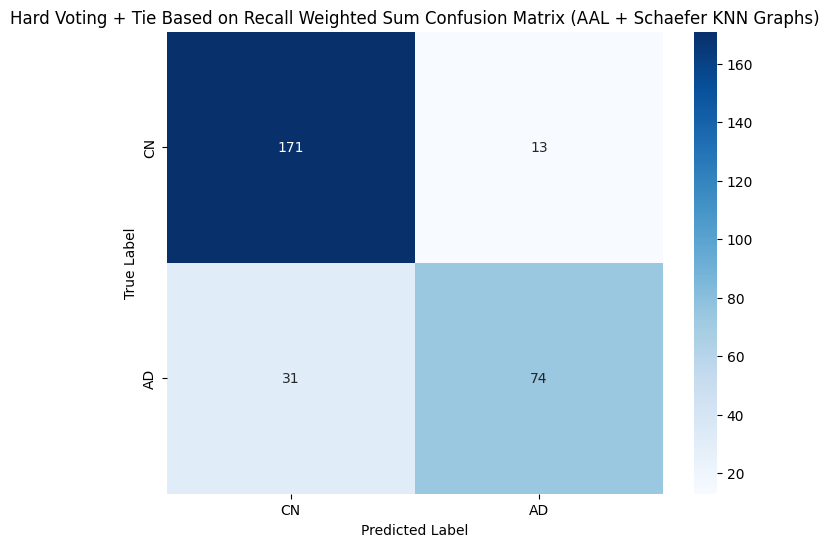

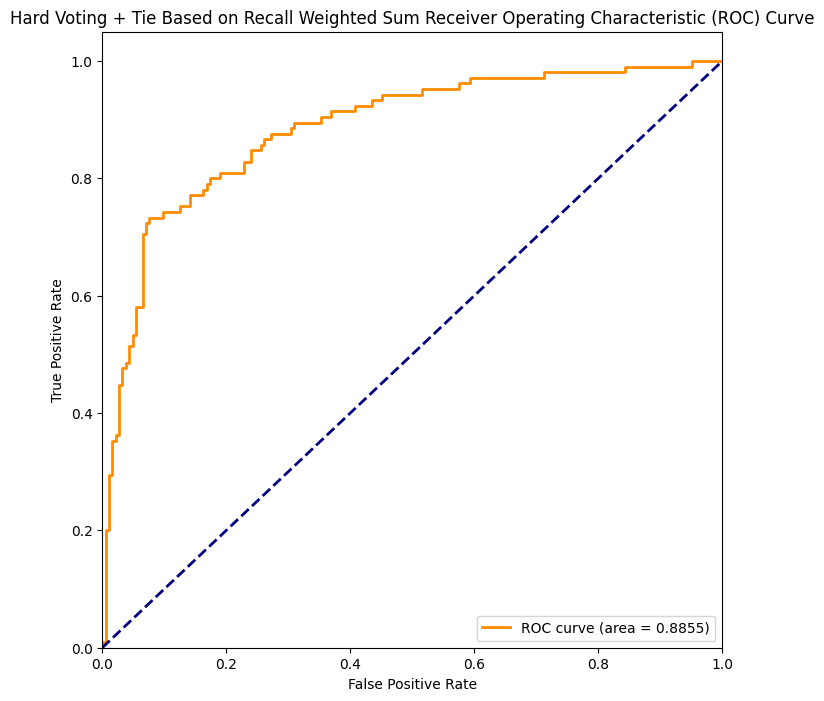

Ensemble AUC: 0.8855

--- Ensemble Analysis Complete ---


In [ ]:
#@title Hard Voting + Tie Based on Recall Weighted Sum Ensemble
# ==============================================================================
# Performing Hard Voting Ensemble with Tie Based on Recall Weighted Sum
# using AAL and Schaefer model predictions and probabilities.
# ==============================================================================

# Assuming all_aal_preds, all_aal_labels, all_aal_probs,
# all_schaefer_preds, all_schaefer_labels, all_schaefer_probs,
# and the fold histories (aal_fold_history, schaefer_fold_history) are available from previous steps.

print("\n" + "="*80)
print(" Starting Hard Voting + Tie Based on Recall Weighted Sum Ensemble")
print("="*80 + "\n")

# --- 1. Load Results and Calculate Recall-based Weights ---

try:
    # Check if AAL results are available
    aal_preds = np.array(all_aal_preds)
    true_labels = np.array(all_aal_labels) # Assuming labels are consistent
    aal_probs = np.array(all_aal_probs)
    print("✅ AAL results variables found.")
except NameError:
    print("--- !!! ERROR !!! ---")
    print("AAL results variables (`all_aal_preds`, `all_aal_labels`, `all_aal_probs`) not found.")
    print("Please ensure you have run the AAL CV cell (bIbT2iLxdvsy) successfully.")
    raise NameError("AAL results not found. Cannot perform ensemble.")


try:
    # Check if Schaefer results are available
    schaefer_preds = np.array(all_schaefer_preds)
    # Assert that labels are the same if needed:
    # assert np.array_equal(true_labels, np.array(all_schaefer_labels)), "AAL and Schaefer labels do not match!"
    schaefer_probs = np.array(all_schaefer_probs)
    print("✅ Schaefer results variables found.")
except NameError:
    print("--- !!! ERROR !!! ---")
    print("Schaefer results variables (`all_schaefer_preds`, `all_schaefer_labels`, `all_schaefer_probs`) not found.")
    print("Please ensure you have run the Schaefer CV cell (X5jV4037Xc4L) successfully.")
    raise NameError("Schaefer results not found. Cannot perform ensemble.")


# Determine weights for weighted sum using the formula: w_j = Recall_j / sum(Recall_i)
# Retrieve average Recalls from the respective fold_history variables
try:
    # Ensure fold_history variables are accessible and contain 'recall'
    aal_avg_recall = np.mean([f['recall'] for f in aal_fold_history])
    schaefer_avg_recall = np.mean([f['recall'] for f in schaefer_fold_history])

    # Calculate total Recall sum
    total_recall_sum = aal_avg_recall + schaefer_avg_recall

    # Calculate weights using the formula w_j = Recall_j / sum(Recall_i)
    if total_recall_sum > 0:
        aal_weight = aal_avg_recall / total_recall_sum
        schaefer_weight = schaefer_avg_recall / total_recall_sum
    else:
        # Handle case where total Recall sum is zero (shouldn't happen with typical Recalls)
        print("Warning: Total Recall sum is zero. Using equal weights (0.5) for tie-breaking.")
        aal_weight = 0.5
        schaefer_weight = 0.5

    print(f"Using Recall-based weights for tie-breaking: AAL={aal_weight:.4f}, Schaefer={schaefer_weight:.4f}")

except NameError:
    print("Warning: Could not access fold_history to get average Recalls for weighted sum calculation.")
    print("Using equal weights (0.5) for tie-breaking.")
    aal_weight = 0.5
    schaefer_weight = 0.5
except Exception as e:
    print(f"Warning: Error calculating Recall-based weights: {e}")
    print("Using equal weights (0.5) for tie-breaking.")
    aal_weight = 0.5
    schaefer_weight = 0.5


# --- 3. Perform Ensemble Prediction (Hard Voting with Recall Weighted Sum for Ties) ---

def ensemble_predict_hard_weighted_tie(aal_preds, aal_probs, schaefer_preds, schaefer_probs, aal_weight, schaefer_weight):
    """
    Performs Hard Voting ensemble with Recall-based Weighted Sum for ties.

    Args:
        aal_preds (np.ndarray): Predicted labels from AAL model (shape: num_samples)
        aal_probs (np.ndarray): Predicted probabilities from AAL model (shape: num_samples, num_classes)
        schaefer_preds (np.ndarray): Predicted labels from Schaefer model (shape: num_samples)
        schaefer_probs (np.ndarray): Predicted probabilities from Schaefer model (shape: num_samples, num_classes)
        aal_weight (float): Weight for AAL model in case of tie-breaking.
        schaefer_weight (float): Weight for Schaefer model in case of tie-breaking.

    Returns:
        np.ndarray: Final ensemble predictions (shape: num_samples)
    """
    num_samples = len(aal_preds)
    ensemble_preds = np.zeros(num_samples, dtype=int)
    # num_classes = aal_probs.shape[1] # Assuming num_classes is consistent

    for i in range(num_samples):
        pred1 = aal_preds[i]
        pred2 = schaefer_preds[i]

        if pred1 == pred2:
            # Hard voting agrees
            ensemble_preds[i] = pred1
        else:
            # Tie in hard voting, use weighted sum of probabilities based on Recall weights
            weighted_probs = (aal_probs[i] * aal_weight) + (schaefer_probs[i] * schaefer_weight)

            # Predict the class with the highest weighted probability
            ensemble_preds[i] = np.argmax(weighted_probs)

    return ensemble_preds


print("\n--- Performing Ensemble Prediction ---")
# Pass the collected results and the calculated weights
ensemble_predictions = ensemble_predict_hard_weighted_tie(aal_preds, aal_probs, schaefer_preds, schaefer_probs, aal_weight, schaefer_weight)


# --- 4. Evaluate Ensemble Performance ---
print("\n--- Evaluating Ensemble Performance ---")

ensemble_accuracy = accuracy_score(true_labels, ensemble_predictions)
ensemble_f1 = f1_score(true_labels, ensemble_predictions, average='weighted')
ensemble_cm = confusion_matrix(true_labels, ensemble_predictions)
ensemble_classification_report_dict = classification_report(true_labels, ensemble_predictions, target_names=['CN', 'AD'], output_dict=True) # Get report as dictionary

# Extract and print individual metrics
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")
print(f"Ensemble F1-Score (weighted): {ensemble_f1:.4f}")
print(f"Ensemble Precision (CN): {ensemble_classification_report_dict['CN']['precision']:.4f}")
print(f"Ensemble Recall (CN): {ensemble_classification_report_dict['CN']['recall']:.4f}")
print(f"Ensemble Precision (AD): {ensemble_classification_report_dict['AD']['precision']:.4f}")
print(f"Ensemble Recall (AD): {ensemble_classification_report_dict['AD']['recall']:.4f}")


print("\nEnsemble Classification Report:")
print(classification_report(true_labels, ensemble_predictions, target_names=['CN', 'AD'], digits=4))

# --- 5. Visualize Ensemble Results ---

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(ensemble_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['CN', 'AD'], yticklabels=['CN', 'AD'])
plt.title('Hard Voting + Tie Based on Recall Weighted Sum Confusion Matrix (AAL + Schaefer KNN Graphs)') # Updated Title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
# For ROC curve, we need the probability of the positive class (AD, label 1) for the ensemble.
# In this Hard Voting + Tie strategy, the ensemble probability isn't a simple overall weighted sum
# of the initial probabilities for *all* samples. For non-tie cases, the ensemble prediction
# is just the agreed-upon label, without a probability derived from probability combination.
# For tie cases, the probability comes from the weighted sum.
# To plot an overall ROC curve, we technically need a probability score for every sample.
# A common approximation is to use the weighted sum of probabilities for *all* samples,
# even though the hard voting logic was applied first. This provides a smooth ROC curve
# based on the probability scores that *would have been used* if it was pure Soft Voting
# with these weights.

# Let's use the weighted sum of probabilities for all samples to plot the ROC curve,
# acknowledging that the hard voting logic introduces a step based on discrete labels first.
# This is a standard approach for plotting ROC of such hybrid methods based on underlying probabilities.

weighted_ensemble_probs_for_roc = (aal_probs * aal_weight) + (schaefer_probs * schaefer_weight)
probs_positive_class_ensemble_for_roc = weighted_ensemble_probs_for_roc[:, 1]


# Ensure true_labels and probs_positive_class_ensemble_for_roc have the same length
if len(true_labels) == len(probs_positive_class_ensemble_for_roc):
    fpr, tpr, thresholds = roc_curve(true_labels, probs_positive_class_ensemble_for_roc)
    roc_auc_ensemble = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_ensemble:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Hard Voting + Tie Based on Recall Weighted Sum Receiver Operating Characteristic (ROC) Curve') # Updated Title
    plt.legend(loc="lower right")
    plt.show()
else:
     print(f"Error: Length of true labels ({len(true_labels)}) does not match length of ensemble probabilities ({len(probs_positive_class_ensemble_for_roc)}). Cannot plot ROC curve.")

print(f"Ensemble AUC: {roc_auc_ensemble:.4f}") # Explicitly print AUC

print("\n--- Ensemble Analysis Complete ---")